(hgf_exercises_2)=
# Application to reinforcement learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Exercise_2_Bayesian_reinforcement_learning.ipynb)

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install pyhgf watermark

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
from pyhgf import load_data
from pyhgf.distribution import HGFDistribution, HGFPointwise
from pyhgf.model import HGF
from pyhgf.response import binary_softmax, first_level_binary_surprise
from pytensor import scan

plt.rcParams["figure.constrained_layout.use"] = True

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## The binary HGF

In the first part of the tutorial, we introduced neural networks for predictive coding, a flexible and modular way to define hierarchically structured systems of predictive nodes. We discussed how value coupling and volatility coupling are two kinds of interactions between nodes that can influence how prediction and prediction errors are propagated through the network.

However, several experiments, especially when considering reinforcement learning, require working with variables that have discrete states. This is the case for example when the agent has to learn the association between one stimulus and a reward. Such experiments, like the [one-armed bandit task](https://en.wikipedia.org/wiki/Multi-armed_bandit) that we will be using below, generally produce two types of information at each trial:
- the action $y$, as a boolean variable, that is registering the decision made by the agent at time $t$, at the beginning of the trial.
- the observation $u$ about the association between the stimuli and the outcomes, as a boolean (e.g. `1` if Stim_1 -> Outcome_1 and Stim_2 -> Outcome_2, `0` if this is the other way around).

That is where the binary Hierarchical Gaussian Filter can be used, and seen as an extension of the continuous HGF to discrete variables. It is built on the same principles, except it uses a binary input to receive observation and a binary state to update expected probability over outcomes. Using a [logit](https://en.wikipedia.org/wiki/Logit) transform, this probability is converted to the continuous domain and predicted by a continuous state node (i.e. the two-level binary HGF). Additionally, another state node can predict the volatility of this later node (i.e. a three-level binary HGF).

Let's start by loading an example dataset from {cite:p}`Iglesias2021` using the following command to return a vector of observations $u$ and a vector of decisions $y$.

In [3]:
u, y = load_data("binary")

```{exercise}
:label: exercise1

Create a two-level binary Hierarchical Gaussian Filter using the `Network` class and plot the network structure.

This network should include:
- A binary input node
- A binary state node, value coupled with the input node
- A continuous state node value coupled with the binary state node

```

It is also possible to create the same network using the `HGF` class, (note that ```model_type="binary"```).

In [4]:
two_levels_hgf = HGF(
    n_levels=2,
    model_type="binary",
    initial_mean={"1": 0.5, "2": 0.0},
    initial_precision={"1": np.nan, "2": 1.0},
    tonic_volatility={"2": -2.0},
)

This is a two-level binary HGF, so we have one continuous node predicting the outcomes of a binary state node.

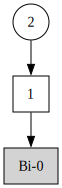

In [5]:
two_levels_hgf.plot_network()

The observations about the associations are provided as input data and will be the sensory information the agent uses to update its beliefs.

In [6]:
two_levels_hgf = two_levels_hgf.input_data(input_data=u)

The node trajectories illustrate how new binary outcomes change the expectations about the associations between the stimuli.

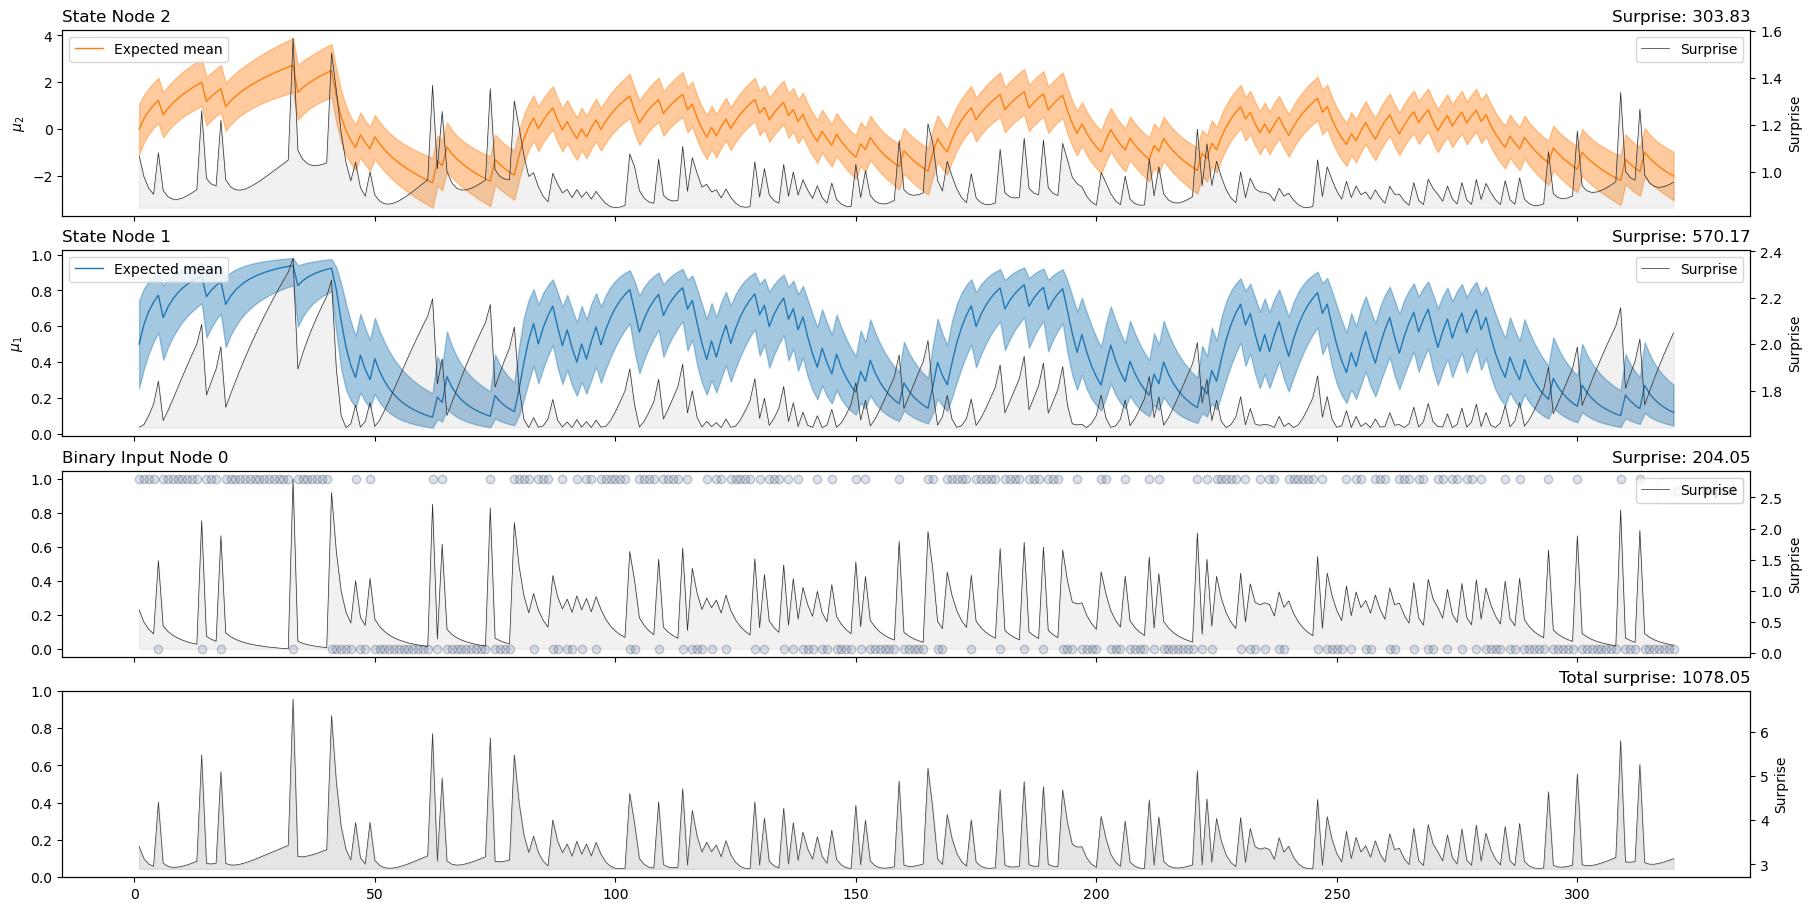

In [7]:
two_levels_hgf.plot_trajectories();

We now have a model with beliefs trajectories and we want to see how these beliefs can explain the behaviour of the participant. This is where we will use the decision vector $y$ together with a response model. Designing response models that are adapted to the task is a central part of the modelling process (you can read more on this in the {ref}`custom_response_functions` section). Here, we use the `binary_softmax`, which means that we assume the expected probability at the first level of the model predicts the decision.

In [8]:
two_levels_hgf.surprise(
    response_function=binary_softmax,  # the response model
    response_function_inputs=y,  # the decision vector
).sum()

Array(123.345825, dtype=float32)

Once we have these two piece of information, we are ready to compute the surprise, which will indicates how well our model could prediction the behavior of the participant.

```{hint}
The actions, or decisions, initiated by the agent are not influencing the way beliefs about the hidden states of the world are being updated (this is NOT active inference). This is for sure a limitation of the model, but it also means that the belief updating and the response model can be processed separately. In other words, no matter what actions the agent is taking along the way, this will not change the way sensory evidence is updating beliefs.
```

```{exercise}
:label: exercise2

- Using the examples above, can you diagnose the performances of the agent?
- What could make it better? Can you try to change the parameters and get an agent with better performances (i.e. minimizing the surprise)?

```

## Parameters optimization

So far we have been running our models forward by fixing the values of the parameters beforehand. This is an important part of the modelling process as we can retrieve the belief trajectories, which indicates how the agent might use sensory information to adapt to the environment, as well as the surprise associated with these observations, which indicates *how well* the agent adapted to the environment. 

In the context of analysing data from a task, we do not want to fit the data manually and retrieve the trajectories from every possible set of parameters. Instead, we want to perform Bayesian inference over these parameters and estimate the posterior of the probability distribution. Here we are going to perform this step using Hamiltonian Monte Carlo sampling as implemented in PyMC.

In [9]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="binary",
    input_data=u[np.newaxis, :],
    response_function=first_level_binary_surprise,
)

In [10]:
with pm.Model() as two_levels_binary_hgf:

    # Set a prior over the evolution rate at the second level.
    tonic_volatility_2 = pm.Uniform("tonic_volatility_2", -3.5, 0.0)

    # Call the pre-parametrized HGF distribution here.
    # All parameters are set to their default value, except omega_2.
    pm.Potential("hgf_loglike", hgf_logp_op(tonic_volatility_2=tonic_volatility_2))

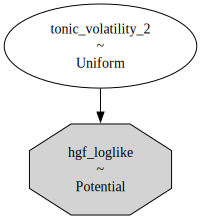

In [11]:
pm.model_to_graphviz(two_levels_binary_hgf)

In [12]:
with two_levels_binary_hgf:
    two_level_hgf_idata = pm.sample(chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [tonic_volatility_2]


Output()

Output()

Output()

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


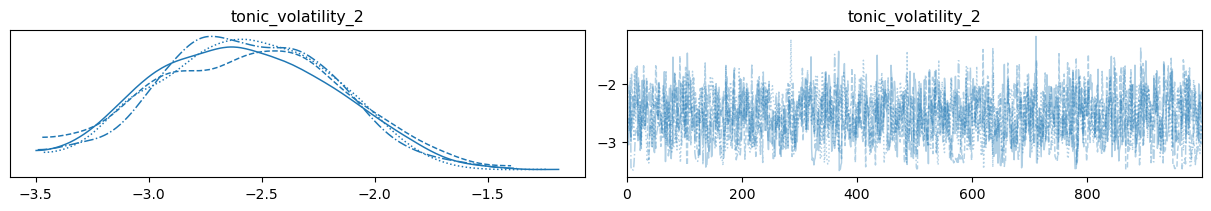

In [13]:
az.plot_trace(two_level_hgf_idata, var_names=["tonic_volatility_2"]);

In [14]:
az.summary(two_level_hgf_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tonic_volatility_2,-2.574,0.395,-3.322,-1.869,0.011,0.008,1231.0,979.0,1.01


## Fitting behaviours to different RL models

When modelling, we always want to control for alternative, simpler explanations. It might be that our subjects are dynamically updating their beliefs under our assumptions. However, sometimes, they might just be responding rather randomly and not show much learning at all. It might also be that they are using a simple learning model that does not require to use of the HGF to capture higher-order volatility. We want to analyse the data using all these models and compare how well they can explain the participant's responses.

### Biased random

To control for this possibility, we define the simpler alternative model below. This model just takes random actions with a single fixed probability. It does not integrate the data from the task at all.

In [15]:
with pm.Model() as biased_random_model:

    # a simple bias toward deciding 1 vs. 0
    bias = pm.Beta("bias", 1.0, 1.0)

    # Likelihood of observed rewards given the value estimates
    likelihood = pm.Bernoulli("likelihood", p=bias, observed=y)

    # sample from this model
    biased_random_idata = pm.sample(
        chains=2, cores=1, idata_kwargs={"log_likelihood": True}
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [bias]


Output()

Output()

Output()

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


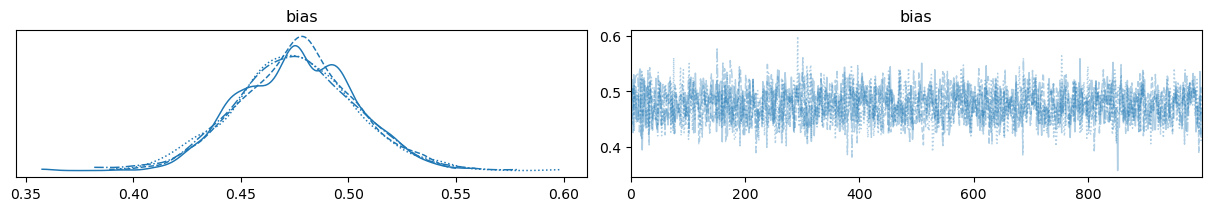

In [16]:
az.plot_trace(biased_random_idata);

Assess model fitting, here using leave-one-out cross-validation from the [Arviz](https://python.arviz.org/en/stable/api/generated/arviz.loo.html) library.

### Rescorla-Wagner

Another popular model in reinforcement learning is the [Rescorla-Wagner model](https://en.wikipedia.org/wiki/Rescorla%E2%80%93Wagner_model), which assumes that the agent uses prediction errors from the previous observation to update its beliefs. Here we create a simple Rescorla-Wagner and try to optimize the learning rate to predict the agent decisions.

Here, we write our models using [PyTensor](https://pytensor.readthedocs.io/en/latest/), which is the tensor library on which [PyMC](https://www.pymc.io/welcome.html) is built, and sample the model the same way. We start by creating an update function at the trial level. This function is later used in [scan](https://pytensor.readthedocs.io/en/latest/library/scan.html), which is how PyTensor implements fast for loop with carry-over variables.

In [17]:
def rw_update(new_observation, current_belief, learning_rate):
    """Update the belief about contingencies at time t."""

    # get the new value using the RW update
    new_belief = current_belief + learning_rate * (new_observation - current_belief)

    return new_belief

In [18]:
with pm.Model() as rw_model:

    observations = pt.as_tensor_variable(u, dtype="int32")
    initial_belief = pm.Beta("initial_belief", 1, 1)

    # prior over the learning rate
    learning_rate = pm.Beta("learning_rate", 1, 1)

    # Apply the Rescorla-Wagner update rule to the sequence of observations
    beliefs, _ = scan(
        fn=rw_update,
        sequences=observations,
        non_sequences=learning_rate,
        outputs_info=initial_belief,
    )

    pm.Deterministic("beliefs", beliefs)

    # compute the likelihood at each trial using a simple sigmoid as response function
    likelihood = pm.Bernoulli("likelihood", p=beliefs, observed=y)

In [19]:
with rw_model:
    rw_idata = pm.sample(chains=2, cores=4, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [initial_belief, learning_rate]
/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/home/nicolas/mambaforge/envs/pyhgf_dev/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


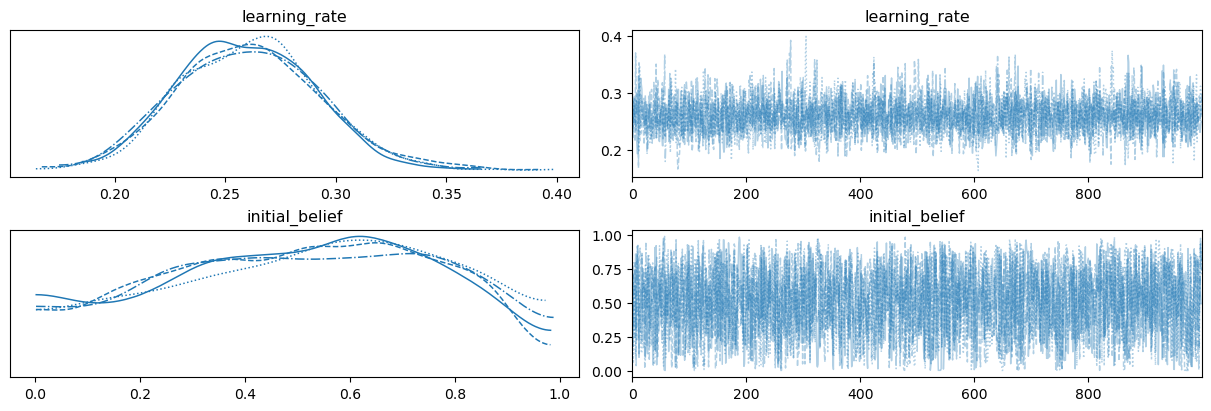

In [20]:
az.plot_trace(rw_idata, var_names=["learning_rate", "initial_belief"]);

### Two-level HGF

Finally, we can model the behaviour using the two-level or the three-level HGF. The two-level model should generate prediction similar to what we have with the Rescorla-Wagner model, while the three-level HGF adds a layer of volatility and therefore could take advantage of higher-level dynamics of volatility.

We start by creating an HGF distribution that works with a two-level binary model. Additionally, we create a similar *pointwise* distribution.

In [21]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="binary",
    input_data=u[np.newaxis, :],
    response_function=binary_softmax,
    response_function_inputs=y[np.newaxis, :],
)

In [22]:
hgf_logp_op_pointwise = HGFPointwise(
    n_levels=2,
    model_type="binary",
    input_data=u[np.newaxis, :],
    response_function=binary_softmax,
    response_function_inputs=y[np.newaxis, :],
)

```{hint} Pointwise distributions
There is a subtle difference between the two: the pointwise distribution will return the log probabilities for every observation in the model (i.e. here for every decision), which is something we need later for model comparison. The regular HGF distribution will return the sum of the log probabilities, which is what we need to perform sampling.
```

We then create two functions that compute the sum of the log probabilities and the log probabilities (respectively), that we use in our model inside a custom distribution or to save a deterministic variable (respectively).

In [23]:
def logp(value, tonic_volatility_2):
    return hgf_logp_op(tonic_volatility_2=tonic_volatility_2)

In [24]:
def logp_pointwise(tonic_volatility_2):
    return hgf_logp_op_pointwise(tonic_volatility_2=tonic_volatility_2)

In [25]:
with pm.Model() as two_levels_binary_hgf:

    # prior over the tonic volatility at the second level
    tonic_volatility_2 = pm.Normal("tonic_volatility_2", -5.0, 2.0)

    # the two-level HGF distribution
    log_likelihood = pm.CustomDist(
        "log_likelihood", 
        tonic_volatility_2, 
        logp=logp, 
        observed=y)

    # save the pointwise log probabilities for model comparison
    pm.Deterministic('pointwise_loglikelihood', logp_pointwise(tonic_volatility_2))

    # sample the model
    two_levels_idata = pm.sample(chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [tonic_volatility_2]


Output()

Output()

Output()

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


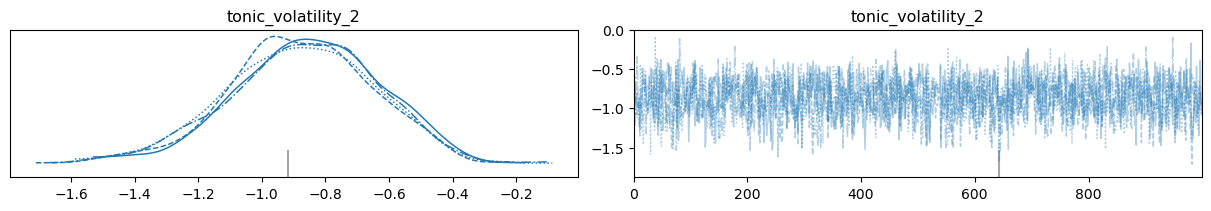

In [26]:
az.plot_trace(two_levels_idata, var_names="tonic_volatility_2");

We have saved the pointwise log probabilities as a variable, here we simply move this variable to the log_likelihoo field of the `idata` object, so [Arviz](https://python.arviz.org/en/stable/) knows that this can be used later for model comparison.

In [27]:
two_levels_idata.add_groups(
    log_likelihood=two_levels_idata.posterior["pointwise_loglikelihood"]
)

### Three-level HGF

We use the same workflow, this time creating a three-level HGF distribution with its pointwise sidecar distribution.

In [28]:
hgf_logp_op = HGFDistribution(
    n_levels=3,
    model_type="binary",
    input_data=u[np.newaxis, :],
    response_function=binary_softmax,
    response_function_inputs=y[np.newaxis, :],
)

In [29]:
hgf_logp_op_pointwise = HGFPointwise(
    n_levels=3,
    model_type="binary",
    input_data=u[np.newaxis, :],
    response_function=binary_softmax,
    response_function_inputs=y[np.newaxis, :],
)

In [30]:
def logp(value, tonic_volatility_2):
    return hgf_logp_op(tonic_volatility_2=tonic_volatility_2)

In [31]:
def logp_pointwise(tonic_volatility_2):
    return hgf_logp_op_pointwise(tonic_volatility_2=tonic_volatility_2)

In [32]:
with pm.Model() as three_levels_binary_hgf:

    # prior over the tonic volatility at the second level
    tonic_volatility_2 = pm.Normal("tonic_volatility_2", -5.0, 2.0)

    # the three-level HGF distribution
    log_likelihood = pm.CustomDist(
        "log_likelihood", 
        tonic_volatility_2, 
        logp=logp, 
        observed=y
    )

    # save the pointwise log probabilities for model comparison
    pm.Deterministic('pointwise_loglikelihood', logp_pointwise(tonic_volatility_2))

    three_levels_idata = pm.sample(chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [tonic_volatility_2]


Output()

Output()

Output()

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.


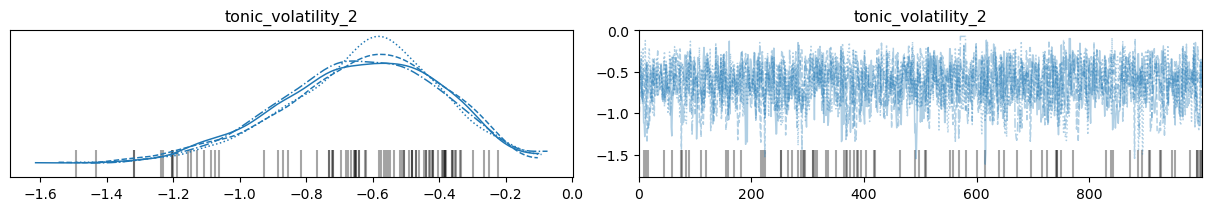

In [33]:
az.plot_trace(three_levels_idata, var_names="tonic_volatility_2");

Move pointwise estimate into the likelihood field.

In [34]:
three_levels_idata.add_groups(
    log_likelihood=three_levels_idata.posterior["pointwise_loglikelihood"]
)

## Model comparison

Finally, we use [Arviz](https://python.arviz.org/en/stable/) to compare the four models we developed to compare the performances of our participants. The comparison simply requires the `idata` variables that are returned by the sampling procedures. The first function uses leave-one-out cross-validation to assess the predictive power of each model. The second function plots the result with estimated standard error.

In [35]:
%%capture --no-display
compare_df = az.compare(
    {
        "biased_random": biased_random_idata,
        "RW": rw_idata,
        "two-level": two_levels_idata,
        "three-level": three_levels_idata,
    }
)

In [36]:
compare_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
three-level,0,-112.611969,0.237226,0.000000,1.000000e+00,4.044890,0.000000,True,log
two-level,1,-113.595734,0.239365,0.983765,0.000000e+00,4.010115,0.103064,True,log
RW,2,-123.069360,0.870602,10.457391,0.000000e+00,5.510167,3.681075,True,log
biased_random,3,-222.367147,0.959951,109.755178,2.605560e-10,0.876223,4.158244,False,log


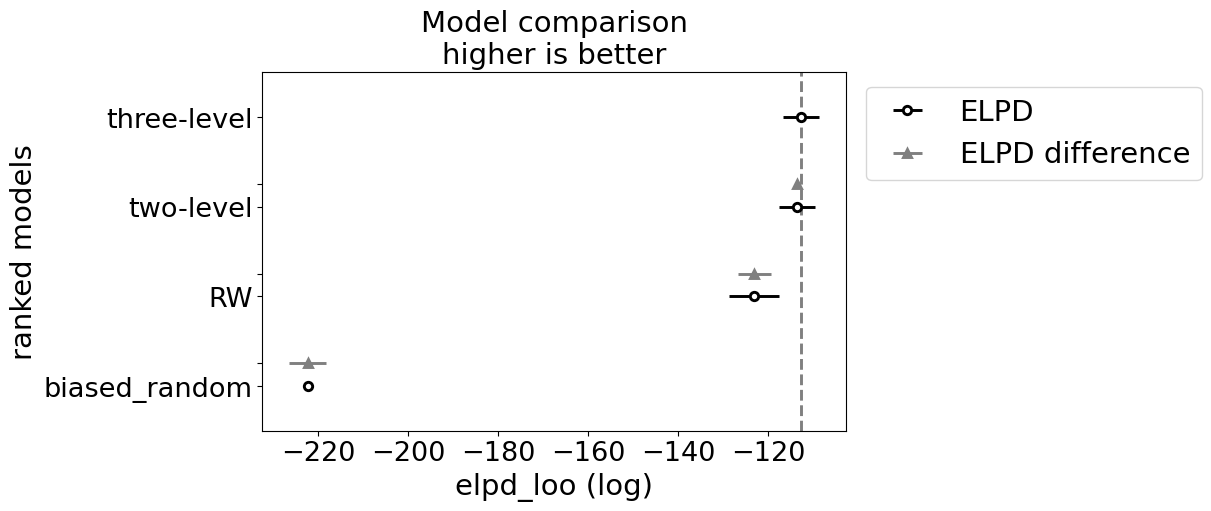

In [37]:
az.plot_compare(compare_df, figsize=(12, 5));

Looking at the final result, we can see that the three-level HGF had the best predictive performance on the participant decision, suggesting that higher-level uncertainty is important here to understand the agent's behaviour.

## Posterior predictive sampling

### Beliefs trajectories

One way to assess model fitting is to use the predictive sample from the posterior distribution to visualize the trajectories of inferred beliefs. We can easily retrieve the trajectories of expected probabilities from the biased random and the Rescorla-Wagner models. For the two and three-level HGF, we will reconstruct the trajectories using the sample values.

In [38]:
two_level_trajectories = []
for tonic_volatility_2 in az.extract(
    two_levels_idata, 
    var_names="tonic_volatility_2", 
    num_samples=10
).to_numpy():

    # extract trajectories
    two_level_trajectories.append(
        HGF(
            n_levels=2,
            model_type="binary",
            initial_mean={"1": 0.5, "2": 0.0},
            initial_precision={"1": np.nan, "2": 1.0},
            tonic_volatility={"2": tonic_volatility_2},
        ).input_data(input_data=u).node_trajectories[1]["expected_mean"]
    )

In [39]:
three_level_trajectories = []
for tonic_volatility_2 in az.extract(
    three_levels_idata, 
    var_names="tonic_volatility_2", 
    num_samples=10
).to_numpy():

    # extract trajectories
    three_level_trajectories.append(
        HGF(
            n_levels=3,
            model_type="binary",
            initial_mean={"1": 0.5, "2": 0.0, "3": 0.0},
            initial_precision={"1": np.nan, "2": 1.0, "3": 1.0},
            tonic_volatility={"2": tonic_volatility_2, "3": -3.0},
        ).input_data(input_data=u).node_trajectories[1]["expected_mean"]
    )

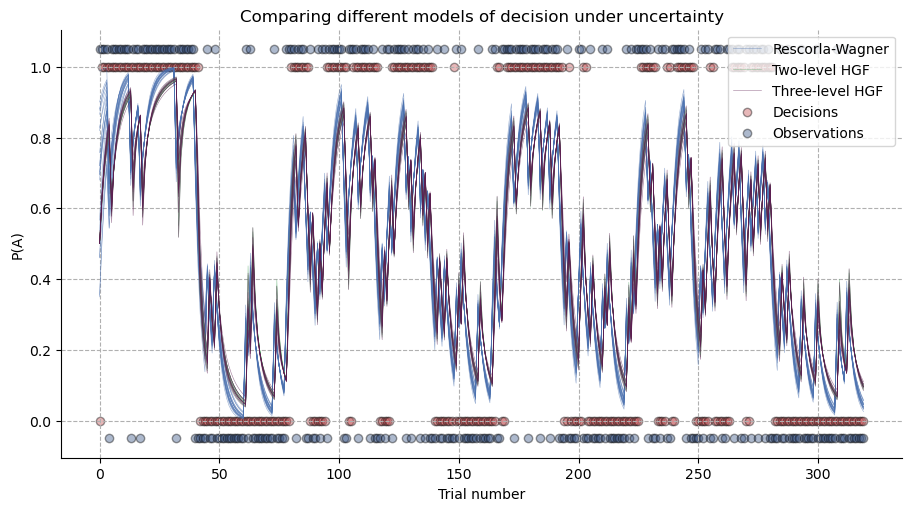

In [40]:
_, ax = plt.subplots(figsize=(9, 5))

ax.plot(
    az.extract(rw_idata, var_names="beliefs", num_samples=20).to_numpy(),
    color="#4c72b0", 
    label="Rescorla-Wagner",
    linewidth=.4,
    alpha=.6,
)
ax.plot(
    np.array(two_level_trajectories).T,
    color="#55a868", 
    label="Two-level HGF",
    linewidth=.4,
    alpha=.6,
)
ax.plot(
    np.array(three_level_trajectories).T,
    color="#5d1e51", 
    label="Three-level HGF",
    linewidth=.4,
    alpha=.6,
)

ax.scatter(
    np.arange(len(y)), y, 
    color="#c44e52", 
    alpha=0.4, 
    edgecolor="k", 
    label="Decisions",
)
ax.scatter(
    np.arange(len(u)), u * 1.1 - .05, 
    color="#345082", 
    alpha=0.4, 
    edgecolor="k", 
    label="Observations",
)

ax.set(
    xlabel="Trial number", 
    ylabel="P(A)", 
    title="Comparing different models of decision under uncertainty")
ax.grid(linestyle="--")

handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique))
sns.despine()

The resulting samples show belief trajectories for 10 samples for each model (we are not depicting the biased random here for clarity). The trajectories are highly similar, but we can see that the two and three-level HGF are slightly adjusting their learning rates in a way that was more consistent with the observed behaviours.

# Where to go next?

Thank you for completing this tutorial on the generalized Hierarchical Gaussian Filter. Let's briefly recap what we have covered so far:

- In the first notebook you learned how to simulate the generative model on which the gHGF is built and how to create probabilistic networks that can invert this model with PyHGF. We applied these principles to real data and tried different parametrisations that could improve model performances.
- In the second notebook we covered the binary HGF, an extension of this model to binary inputs for reinforcement learning. We then used MCMC sampling to infer the probability distribution of key parameters and compared the performances of our model to other RL classics.

All these sections should give you a solid understanding of the model and how to use it in context. If you want to apply this to your dataset, we recommend exploring the tutorial section of the documentation:

- [Using custom response models](https://ilabcode.github.io/pyhgf/notebooks/2-Using_custom_response_functions.html) will explore the creation of custom models for behaviours that can match your experimental design and theory.
- [Multilevel modelling](https://ilabcode.github.io/pyhgf/notebooks/3-Multilevel_HGF.html) will discuss modelling at the group/condition level in multilevel Bayesian networks.
- [Parameter recovery](https://ilabcode.github.io/pyhgf/notebooks/4-Parameter_recovery.html) explains how to simulate a dataset and perform parameter recovery, as a prior validation of your models.

# Solutions

````{solution} exercise1
:label: solution-exercise1

Here's how we can create the network.

```{code-block} python
binary_hgf = (
    Network()
    .add_nodes(kind="binary-input")
    .add_nodes(kind="binary-state", value_children=0)
    .add_nodes(kind="continuous-state", value_children=1)
)
```

Here's how to plot the network.

```{code-block} python
binary_hgf.plot_network()
```

````

````{solution} exercise2
:label: solution-exercise2

- Looking at the trajectories, both at the first and the second level (remember that the binary state node and the continuous state node are encoding the sa values using different scales), we can see that the agent is rather slow at changing its mind when the observed associations between the stimuli and the outcomes are switching. 

- How fast the agent changes its mind is controlled by the learning rate (in the context of a Rescorla-Wagner model for example). Here, this quantity is controlled by the tonic volatility at the second level. In the previous example, we can see that this quantity was set to `-5.0`. We can try to set it to something higher (e.g. `-2.0`), which will produce noisier time series, and also minimize the surprise. The agent uses a more quickly updated belief about the hidden associations, therefore the decisions track the actual state of the experiment and are more accurate on average.
````

# System configuration

In [41]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Wed Sep 11 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.23.0

pyhgf : 0.1.4
jax   : 0.4.31
jaxlib: 0.4.31

pytensor  : 2.25.2
arviz     : 0.19.0
sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
numpy     : 1.26.0
matplotlib: 3.8.4
seaborn   : 0.13.2
pymc      : 5.16.2

Watermark: 2.4.3

